# Pendulum solution for inverse dynamics problem

Mixed data for training

In [1]:
import os
import pandas as pd
import numpy as np
import torch

from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

np.set_printoptions(precision=6, suppress=True)

In [2]:
base = '../../data/interim'
data_path = 'pendulum/mixed1.csv'
full_path = os.path.join(base, data_path)

raw = pd.read_csv(full_path, index_col=[0])

In [3]:
raw

,time,qpos,qvel,qacc,ctrl
id,,,,,
0,0.001,[-5.27405987e-05],[-0.0527406],[-52.74059872],[-57.4872526]
1,0.002,[-0.00013264],[-0.07989561],[-27.15500922],[-29.59911526]
2,0.003,[-0.00021852],[-0.08588338],[-5.9877766],[-6.52706684]
3,0.004,[-0.00031071],[-0.09218989],[-6.30650874],[-6.87473762]
4,0.005,[-0.00044756],[-0.13684961],[-44.65972047],[-48.68000974]
...,...,...,...,...,...
9996,9.997,[-0.21983196],[-10.27279336],[-0.59107911],[-1.25650477]
9997,9.998,[-0.23010502],[-10.27306919],[-0.27583014],[-0.94242199]
9998,9.999,[-0.24037805],[-10.27302979],[0.03939156],[-0.62830199]


In [4]:
def str_to_list(s: str) -> np.ndarray:
    return np.fromstring(s[1: -1], dtype=float, sep=' ')


def transform_to_numpy(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    x_res = []
    y_res = []

    for _, row in df.iterrows():
        row = row.to_list()[1:]
        x_res.append(np.r_[str_to_list(row[0]), str_to_list(row[1]), str_to_list(row[2])])
        y_res.append(str_to_list(row[3]))

    return np.array(x_res), np.array(y_res)

In [5]:
x_data, y_data = transform_to_numpy(raw)

x_data.shape, y_data.shape

((20002, 3), (20002, 1))

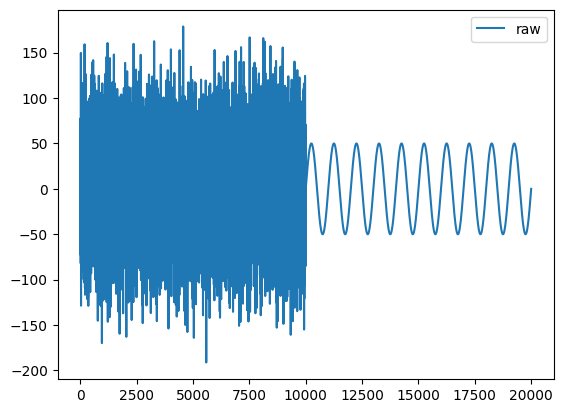

In [6]:

# filter acceleration
qacc = y_data[:, 0]

# # apply median filter with window 3
# qacc_filtered = np.zeros_like(qacc)

# import scipy.signal as signal

# apply median filter
# qacc_filtered = signal.medfilt(qacc, 101)

plt.plot(qacc, label="raw")
# plt.plot(qacc_filtered, label="filtered")
plt.legend()

# y_data = qacc_filtered.reshape(-1, 1)

In [7]:

# # filter acceleration
# qacc = y_data[:, 0]

# # apply median filter with window 3
# qacc_filtered = np.zeros_like(qacc)

# import scipy.signal as signal

# # apply median filter
# qacc_filtered = signal.medfilt(qacc, 101)

# plt.plot(qacc, label="raw")
# plt.plot(qacc_filtered, label="filtered")
# plt.legend()

# # y_data = qacc_filtered.reshape(-1, 1)

In [8]:

proportion = 0.2
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=proportion, random_state=42)

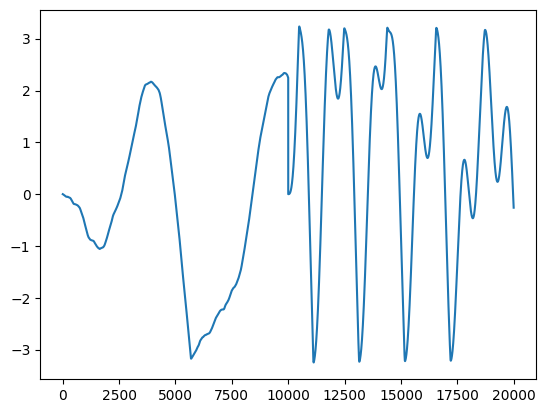

In [9]:
# target position
plt.plot(x_data[:, 0])

In [10]:
train_loader = DataLoader(
    TensorDataset(torch.tensor(x_train), torch.tensor(y_train)),
    batch_size=20,
    shuffle=True
)
val_loader = DataLoader(
    TensorDataset(torch.tensor(x_test), torch.tensor(y_test)),
    batch_size=20,
    shuffle=True
)

In [11]:
class Naive(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, dtype: torch.dtype = torch.float64):
        super(Naive, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.Sigmoid(),
            nn.Linear(100, output_dim),
        ).type(dtype)

    def forward(self, x):
        return self.model(x)

In [12]:
def to_device(_device: torch.device, *tensors: torch.Tensor) -> tuple[torch.Tensor, ...]:
    return tuple(t.to(_device) for t in tensors)


def train_one_epoch(
        _model: nn.Module,
        _optimizer: torch.optim.Optimizer,
        _loss_fn: torch.nn.Module,
        _train_loader: DataLoader,
        _epoch_num: int,
        _device: torch.device = "cpu",
        _ckpt_path: str = "best.pt",
):
    # best score for checkpointing
    _best = np.inf

    # training loop description
    _model.train()
    _train_loss = 0.0
    # iterate over dataset
    for i, data in enumerate(_train_loader, 1):
        _x, _y = to_device(_device, *data)

        # zero the parameter gradients
        _optimizer.zero_grad()

        # forward pass and loss calculation
        _outputs = _model(_x)
        _loss = _loss_fn(_outputs, _y)

        # backward pass
        _loss.backward()

        # optimizer run
        _optimizer.step()

        _train_loss += _loss.item()

    print(f'Epoch {_epoch_num}, Loss: {_train_loss / len(_train_loader)}')


def val_one_epoch(
        _model: nn.Module,
        _optimizer: torch.optim.Optimizer,
        _loss_fn: torch.nn.Module,
        _val_loader: DataLoader,
        _best: float,
        _epoch_num: int,
        _device: torch.device = "cpu",
        _ckpt_path: str = "best.pt",
):
    # validation
    _val_loss = 0.0
    with torch.no_grad():
        _model.eval()  # evaluation mode
        for i, data in enumerate(_val_loader, 1):
            _x, _y = to_device(_device, *data)

            _outputs = _model(_x)
            _val_loss += _loss_fn(_outputs, _y).item()

        print(f'Validation {_epoch_num}, Loss: {_val_loss / len(_val_loader)}')

        if _val_loss / len(_val_loader) > _best:
            torch.save(_model.state_dict(), _ckpt_path)
            _best = _val_loss / len(_val_loader)
    return _best


def train(
        _model: nn.Module,
        _optimizer: torch.optim.Optimizer,
        _loss_fn: torch.nn.Module,
        _train_loader: DataLoader,
        _val_loader: DataLoader,
        _epochs: int,
        _device: torch.device = "cpu",
        _ckpt_path: str = "best.pt",
):
    best = -float('inf')
    for epoch in range(_epochs):
        train_one_epoch(_model, _optimizer, _loss_fn, _train_loader, epoch, _device, _ckpt_path)
        best = val_one_epoch(_model, _optimizer, _loss_fn, _val_loader, best, epoch, _device, _ckpt_path)

In [13]:
device = 'cpu' # 'cuda' if torch.cuda.is_available else 'cpu'
model = Naive(x_data.shape[1], y_data.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
loss_fn = torch.nn.MSELoss()
# writer = SummaryWriter()

In [14]:
train(model, optimizer, loss_fn, train_loader, val_loader, 30, device)

Epoch 0, Loss: 1021.5781189376994
Validation 0, Loss: 547.930805427634
Epoch 1, Loss: 368.68468285558686
Validation 1, Loss: 278.96931313510606
Epoch 2, Loss: 224.83333454516332
Validation 2, Loss: 193.07317795500828
Epoch 3, Loss: 171.12729328515078
Validation 3, Loss: 189.98118718438013
Epoch 4, Loss: 145.8934974917569
Validation 4, Loss: 132.9805844905459
Epoch 5, Loss: 133.55526693234367
Validation 5, Loss: 119.92431156419131
Epoch 6, Loss: 127.41766111131989
Validation 6, Loss: 113.47457505319575
Epoch 7, Loss: 124.70503162221385
Validation 7, Loss: 111.01436773497247
Epoch 8, Loss: 121.56776812695708
Validation 8, Loss: 105.85492491236624
Epoch 9, Loss: 116.89152211873419
Validation 9, Loss: 102.88842628333265
Epoch 10, Loss: 115.08600366728628
Validation 10, Loss: 100.28354273965411
Epoch 11, Loss: 113.79471581379981
Validation 11, Loss: 98.90265976547505
Epoch 12, Loss: 112.65488468346753
Validation 12, Loss: 106.47522520772746
Epoch 13, Loss: 111.75729330117748
Validation 13, 

In [15]:
predicted_tensor = model(torch.tensor(x_data).to(device))
predicted_torque: np.ndarray = predicted_tensor.cpu().detach().numpy()

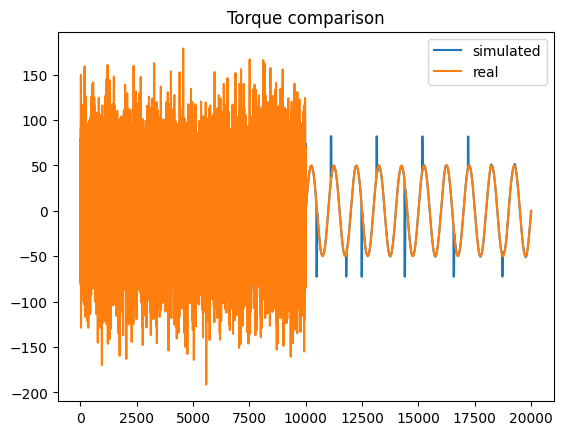

In [16]:
plt.title("Torque comparison")
plt.plot(predicted_torque, label="simulated")
plt.plot(y_data[:, 0], label="real")
plt.legend()

In [17]:
predicted_torque.shape, y_data.shape

((20002, 1), (20002, 1))

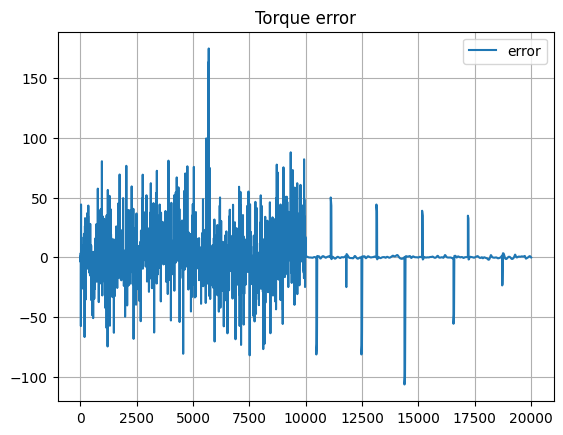

In [18]:
plt.title("Torque error")
plt.plot((predicted_torque - y_data), label="error")
plt.grid()
plt.legend()

# Try on another experiment

In [19]:
base = '../../data/raw'
data_path = 'pendulum/20231006143407765688.csv'
full_path = os.path.join(base, data_path)

experiment = pd.read_csv(full_path, index_col=[0])
x_data, y_data = transform_to_numpy(experiment)
predicted_tensor = model(torch.tensor(x_data).to(device))
predicted_torque: np.ndarray = predicted_tensor.cpu().detach().numpy()

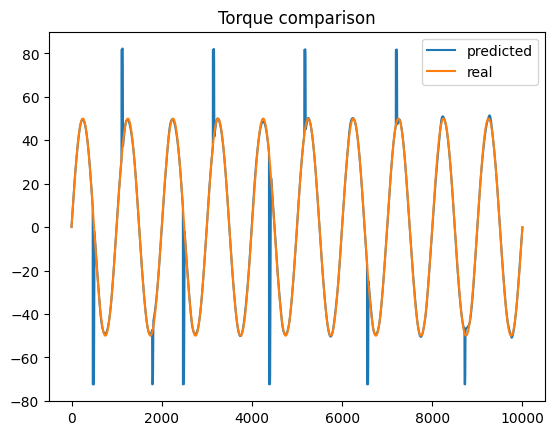

In [20]:
plt.title("Torque comparison")
plt.plot(predicted_torque, label="predicted")
plt.plot(y_data[:, 0], label="real")
plt.legend()

In [21]:
base = '../../data/raw'
data_path = 'pendulum/20231006143323978062.csv'
full_path = os.path.join(base, data_path)

experiment = pd.read_csv(full_path, index_col=[0])
x_data, y_data = transform_to_numpy(experiment)
predicted_tensor = model(torch.tensor(x_data).to(device))
predicted_torque: np.ndarray = predicted_tensor.cpu().detach().numpy()

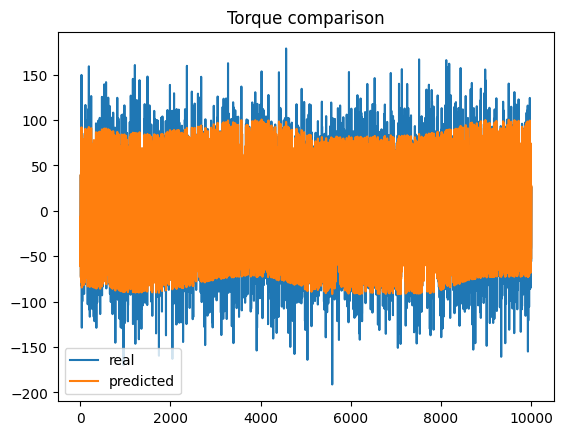

In [22]:
plt.title("Torque comparison")
plt.plot(y_data[:, 0], label="real")
plt.plot(predicted_torque, label="predicted")
plt.legend()

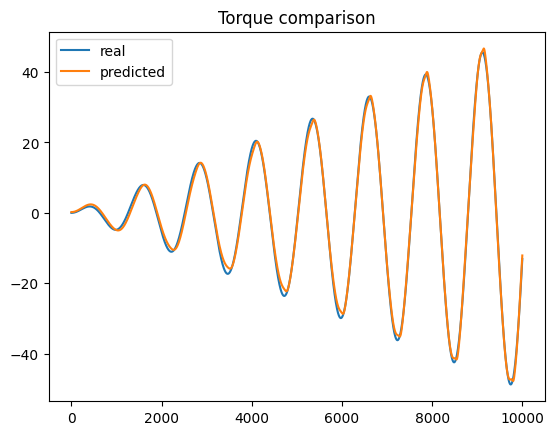

In [23]:
base = '../../data/raw'
data_path = 'pendulum/20231006144628546902.csv'
full_path = os.path.join(base, data_path)

experiment = pd.read_csv(full_path, index_col=[0])
x_data, y_data = transform_to_numpy(experiment)
predicted_tensor = model(torch.tensor(x_data).to(device))
predicted_torque: np.ndarray = predicted_tensor.cpu().detach().numpy()

plt.title("Torque comparison")
plt.plot(y_data[:, 0], label="real")
plt.plot(predicted_torque, label="predicted")
plt.legend()

In [26]:
loss_fn(torch.tensor(y_data), torch.tensor(predicted_tensor))

/tmp/ipykernel_34870/3659702602.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_fn(torch.tensor(y_data), torch.tensor(predicted_tensor))


tensor(0.8817, dtype=torch.float64)